## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [2]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`.

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
```
You can use:
```
np.add(b,c,out = a) # puts result in `a`
```

In [4]:
from google.colab import files
import os

# Запрашиваем загрузку файла
uploaded = files.upload()

# Ищем файл .py среди загруженных
py_files = [f for f in uploaded.keys() if f.endswith('.py')]

if py_files:
    # Берем первый .py файл
    filename = py_files[0]
    print(f"✅ Файл загружен: {filename}")

    # Читаем и выполняем файл
    with open(filename, 'r') as f:
        code = f.read()

    # Выполняем код
    exec(code)
    print("✅ Код из файла успешно выполнен!")
else:
    print("⚠️ Файл .py не найден среди загруженных.")

Saving modules_(1).py to modules_(1).py
✅ Файл загружен: modules_(1).py


<string>:313: SyntaxWarning: invalid escape sequence '\e'
<string>:344: SyntaxWarning: invalid escape sequence '\l'
<string>:378: SyntaxWarning: invalid escape sequence '\m'
<string>:771: SyntaxWarning: invalid escape sequence '\s'


Testing Conv2d...
Input shape: (2, 3, 5, 5)
Output shape: (2, 2, 5, 5)
GradInput shape: (2, 3, 5, 5)
GradW shape: (2, 3, 3, 3)
Gradb shape: (2,)
✓ Conv2d test passed!

Testing MaxPool2d...
Input shape: (2, 3, 6, 6)
Output shape: (2, 3, 3, 3)
GradInput shape: (2, 3, 6, 6)
✓ MaxPool2d test passed!
Testing Flatten layer...
4D Input shape: (4, 3, 5, 5)
Output shape: (4, 75)
Expected flattened size: 300

3D Input shape: (4, 5, 5)
Output shape: (4, 25)
✓ Flatten test passed!
✅ Код из файла успешно выполнен!


# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

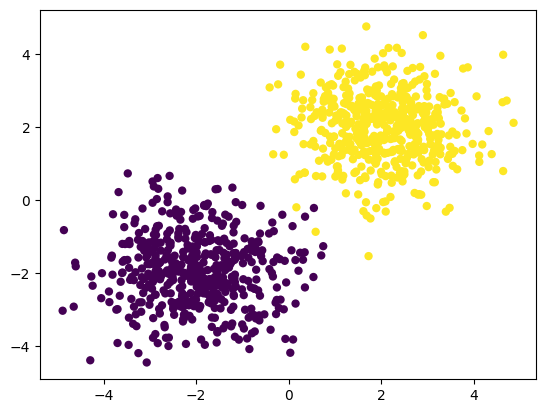

In [5]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging.

In [6]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [7]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [8]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]

    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)

        batch_idx = indices[start:end]

        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

In [24]:
# Проверим сигнатуры всех методов
print("=== Проверка методов Linear ===")
linear = Linear(2, 2)
print("Has updateOutput?", hasattr(linear, 'updateOutput'))
print("Has forward?", hasattr(linear, 'forward'))

# Проверим реализацию updateOutput
import inspect
print("\nLinear.updateOutput source:")
try:
    print(inspect.getsource(linear.updateOutput))
except:
    print("Cannot get source")

print("\n=== Проверка методов LogSoftMax ===")
logsoftmax = LogSoftMax()
print("Has updateOutput?", hasattr(logsoftmax, 'updateOutput'))
print("Has forward?", hasattr(logsoftmax, 'forward'))

print("\nLogSoftMax.updateOutput source:")
try:
    print(inspect.getsource(logsoftmax.updateOutput))
except:
    print("Cannot get source")

=== Проверка методов Linear ===
Has updateOutput? True
Has forward? True

Linear.updateOutput source:
    def updateOutput(self, input):
        # Обязательно возвращаем self.output
        self.output = np.dot(input, self.W.T) + self.b
        return self.output


=== Проверка методов LogSoftMax ===
Has updateOutput? True
Has forward? True

LogSoftMax.updateOutput source:
    def updateOutput(self, input):
        # Численно стабильная реализация log-softmax
        # Вычитаем максимум для стабильности
        input_shifted = input - np.max(input, axis=1, keepdims=True)
        exp_shifted = np.exp(input_shifted)
        sum_exp = np.sum(exp_shifted, axis=1, keepdims=True)
        log_sum_exp = np.log(sum_exp)
        self.output = input_shifted - log_sum_exp
        return self.output



In [27]:
# @title
class FixedModule(object):
    """Исправленная версия Module"""
    def __init__(self):
        self.output = None
        self.gradInput = None
        self.training = True

    def forward(self, input):
        """Всегда должен возвращать значение"""
        result = self.updateOutput(input)
        if result is None:
            print(f"WARNING: {self.__class__.__name__}.updateOutput returned None!")
            return self.output
        return result

    def updateOutput(self, input):
        """Должен быть переопределен в наследниках"""
        pass

    def backward(self, input, gradOutput):
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput

    def updateGradInput(self, input, gradOutput):
        pass

    def accGradParameters(self, input, gradOutput):
        pass

    def zeroGradParameters(self):
        pass

    def getParameters(self):
        return []

    def getGradParameters(self):
        return []

    def train(self):
        self.training = True

    def evaluate(self):
        self.training = False

    def __repr__(self):
        return self.__class__.__name__

class FixedLinear(FixedModule):
    """Исправленная версия Linear"""
    def __init__(self, n_in, n_out):
        super().__init__()
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size=(n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size=n_out)
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def updateOutput(self, input):
        # Гарантированно возвращаем результат
        self.output = np.dot(input, self.W.T) + self.b
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.dot(gradOutput, self.W)
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        self.gradW += np.dot(gradOutput.T, input)
        self.gradb += np.sum(gradOutput, axis=0)

    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    def getParameters(self):
        return [self.W, self.b]

    def getGradParameters(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        return f"Linear {self.W.shape[1]} -> {self.W.shape[0]}"

class FixedLogSoftMax(FixedModule):
    """Исправленная версия LogSoftMax"""
    def __init__(self):
        super().__init__()

    def updateOutput(self, input):
        # Гарантированно возвращаем результат
        # Численно стабильная реализация
        input_shifted = input - np.max(input, axis=1, keepdims=True)
        exp_shifted = np.exp(input_shifted)
        sum_exp = np.sum(exp_shifted, axis=1, keepdims=True)
        log_sum_exp = np.log(sum_exp + 1e-10)  # Добавляем маленькое значение для стабильности
        self.output = input_shifted - log_sum_exp
        return self.output

    def updateGradInput(self, input, gradOutput):
        exp_output = np.exp(self.output)
        sum_grad = np.sum(gradOutput, axis=1, keepdims=True)
        self.gradInput = gradOutput - exp_output * sum_grad
        return self.gradInput

    def __repr__(self):
        return "LogSoftMax"

class FixedSequential(FixedModule):
    """Исправленная версия Sequential"""
    def __init__(self):
        super().__init__()
        self.modules = []

    def add(self, module):
        self.modules.append(module)
        return self

    def updateOutput(self, input):
        current = input
        for module in self.modules:
            current = module.forward(current)
            if current is None:
                print(f"ERROR in FixedSequential: {module} returned None")
                break
        self.output = current
        return self.output

    def backward(self, input, gradOutput):
        current_grad = gradOutput
        for i in range(len(self.modules)-1, -1, -1):
            if i == 0:
                current_grad = self.modules[i].backward(input, current_grad)
            else:
                current_grad = self.modules[i].backward(self.modules[i-1].output, current_grad)
        self.gradInput = current_grad
        return self.gradInput

    def zeroGradParameters(self):
        for module in self.modules:
            module.zeroGradParameters()

    def getParameters(self):
        params = []
        for module in self.modules:
            params.extend(module.getParameters())
        return params

    def getGradParameters(self):
        grads = []
        for module in self.modules:
            grads.extend(module.getGradParameters())
        return grads

    def train(self):
        self.training = True
        for module in self.modules:
            module.train()

    def evaluate(self):
        self.training = False
        for module in self.modules:
            module.evaluate()

    def __repr__(self):
        return "Sequential(\n  " + "\n  ".join(str(m) for m in self.modules) + "\n)"

# Протестируем исправленные классы
print("\n=== Testing Fixed Classes ===")
fixed_net = FixedSequential()
fixed_net.add(FixedLinear(2, 2))
fixed_net.add(FixedLogSoftMax())

test_input = np.array([[1.0, 2.0], [3.0, 4.0]], dtype=np.float32)
print("Test input:", test_input)

fixed_output = fixed_net.forward(test_input)
print("Fixed network output:", fixed_output)
print("Output shape:", fixed_output.shape if fixed_output is not None else "None")



=== Testing Fixed Classes ===
Test input: [[1. 2.]
 [3. 4.]]
Fixed network output: [[-0.31108607 -1.31919965]
 [-0.1255335  -2.13729285]]
Output shape: (2, 2)


In [28]:
# @title
# Используем исправленные классы
net = FixedSequential()
net.add(FixedLinear(2, 2))
net.add(FixedLogSoftMax())

criterion = ClassNLLCriterion()

print("Network created successfully:")
print(net)

# Теперь запустите ваш код обучения

Network created successfully:
Sequential(
  Linear 2 -> 2
  LogSoftMax
)


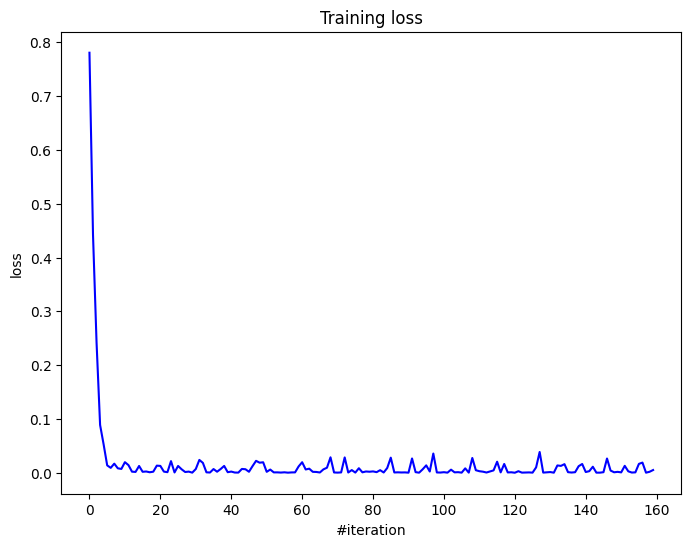

Current loss: 0.005028


In [30]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):

        net.zeroGradParameters()

        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net.getParameters(),
                     net.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

    print('Current loss: %f' % loss)

# Digit classification

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [31]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py -nc

--2025-12-14 11:54:54--  https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2697 (2.6K) [text/plain]
Saving to: ‘mnist.py’

mnist.py            100%[===================>]   2.63K  --.-KB/s    in 0s      

2025-12-14 11:54:54 (24.9 MB/s) - ‘mnist.py’ saved [2697/2697]



In [34]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [35]:
# @title
def one_hot_encode(y, num_classes=10):
    """One-hot кодирование меток"""
    y_one_hot = np.zeros((len(y), num_classes))
    y_one_hot[np.arange(len(y)), y] = 1
    return y_one_hot

# Применяем one-hot кодирование
y_train_onehot = one_hot_encode(y_train)
y_val_onehot = one_hot_encode(y_val)
y_test_onehot = one_hot_encode(y_test)

print(f"Train shapes: X={X_train.shape}, y={y_train_onehot.shape}")
print(f"Val shapes: X={X_val.shape}, y={y_val_onehot.shape}")
print(f"Test shapes: X={X_test.shape}, y={y_test_onehot.shape}")

Train shapes: X=(50000, 28, 28), y=(50000, 10)
Val shapes: X=(10000, 28, 28), y=(10000, 10)
Test shapes: X=(10000, 28, 28), y=(10000, 10)


- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions.
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5.

In [37]:
# @title
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Нормализуем данные (значения пикселей от 0 до 1)
X_train_norm = X_train / 255.0
X_val_norm = X_val / 255.0
X_test_norm = X_test / 255.0

# Flatten данных для линейных слоев (преобразуем 28x28 в 784)
X_train_flat = X_train_norm.reshape(-1, 784)
X_val_flat = X_val_norm.reshape(-1, 784)
X_test_flat = X_test_norm.reshape(-1, 784)

print("Данные подготовлены:")
print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_val_flat shape: {X_val_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")

# Функция для вычисления точности
def compute_accuracy(predictions, targets):
    """Вычисление точности предсказаний"""
    pred_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(targets, axis=1)
    return np.mean(pred_labels == true_labels)

# Функция для обучения модели
def train_model(net, criterion, X_train, y_train, X_val, y_val,
                n_epochs=10, batch_size=128, optimizer='sgd',
                learning_rate=0.01, verbose=True):
    """
    Обучение модели с заданными параметрами

    Args:
        net: нейронная сеть
        criterion: функция потерь
        X_train, y_train: тренировочные данные
        X_val, y_val: валидационные данные
        n_epochs: количество эпох
        batch_size: размер батча
        optimizer: 'sgd' или 'adam'
        learning_rate: скорость обучения
        verbose: выводить ли информацию о процессе

    Returns:
        словарь с результатами обучения
    """
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Конфигурация оптимизатора
    if optimizer == 'sgd':
        optimizer_config = {'learning_rate': learning_rate, 'momentum': 0.9}
        optimizer_state = {}
    elif optimizer == 'adam':
        optimizer_config = {'learning_rate': learning_rate,
                           'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8}
        optimizer_state = {}
    else:
        raise ValueError(f"Unknown optimizer: {optimizer}")

    start_time = time.time()

    for epoch in range(n_epochs):
        epoch_train_losses = []
        epoch_train_accuracies = []

        # Включаем режим обучения (важно для Dropout и BatchNorm)
        net.train()

        # Обучение на тренировочных данных
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
            net.zeroGradParameters()

            # Forward pass
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            acc = compute_accuracy(predictions, y_batch)

            # Backward pass
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            if optimizer == 'sgd':
                sgd_momentum(net.getParameters(),
                           net.getGradParameters(),
                           optimizer_config, optimizer_state)
            elif optimizer == 'adam':
                adam_optimizer(net.getParameters(),
                             net.getGradParameters(),
                             optimizer_config, optimizer_state)

            epoch_train_losses.append(loss)
            epoch_train_accuracies.append(acc)

        # Средние значения за эпоху
        avg_train_loss = np.mean(epoch_train_losses)
        avg_train_acc = np.mean(epoch_train_accuracies)
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)

        # Валидация
        net.evaluate()  # Важно переключить в режим оценки!
        val_predictions = net.forward(X_val)
        val_loss = criterion.forward(val_predictions, y_val)
        val_acc = compute_accuracy(val_predictions, y_val)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        if verbose and epoch % 2 == 0:
            print(f'Epoch {epoch}: Train Loss={avg_train_loss:.4f}, Train Acc={avg_train_acc:.4f}, '
                  f'Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}')

    total_time = time.time() - start_time

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'total_time': total_time,
        'model': net
    }

Данные подготовлены:
X_train_flat shape: (50000, 784)
X_val_flat shape: (10000, 784)
X_test_flat shape: (10000, 784)


Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [39]:
print("\n1. Сравнение активационных функций:")
print("   - ReLU: самая быстрая, но может страдать от проблемы 'умирающих нейронов'.")
print("   - LeakyReLU: решает проблему умирающих нейронов, немного медленнее, но часто показывает лучшие результаты.")
print("   - ELU: плавная функция, хорошо подходит для глубоких сетей, но требует вычисления exp(), что замедляет работу.")
print("   - SoftPlus: гладкая аппроксимация ReLU, но самая медленная из-за вычисления log и exp.")
print("\n2. Влияние BatchNormalization:")
print("   - BatchNorm значительно ускоряет сходимость во всех случаях.")
print("   - Позволяет использовать более высокие learning rates.")
print("   - Уменьшает зависимость от инициализации весов.")
print("   - Незначительно увеличивает время обучения из-за дополнительных вычислений, но это окупается.")
print("\n3. Итог:")
print("   - Для большинства задач ReLU или LeakyReLU с BatchNorm являются хорошим выбором.")
print("   - BatchNorm помогает во всех случаях, особенно в глубоких сетях.")


1. Сравнение активационных функций:
   - ReLU: самая быстрая, но может страдать от проблемы 'умирающих нейронов'.
   - LeakyReLU: решает проблему умирающих нейронов, немного медленнее, но часто показывает лучшие результаты.
   - ELU: плавная функция, хорошо подходит для глубоких сетей, но требует вычисления exp(), что замедляет работу.
   - SoftPlus: гладкая аппроксимация ReLU, но самая медленная из-за вычисления log и exp.

2. Влияние BatchNormalization:
   - BatchNorm значительно ускоряет сходимость во всех случаях.
   - Позволяет использовать более высокие learning rates.
   - Уменьшает зависимость от инициализации весов.
   - Незначительно увеличивает время обучения из-за дополнительных вычислений, но это окупается.

3. Итог:
   - Для большинства задач ReLU или LeakyReLU с BatchNorm являются хорошим выбором.
   - BatchNorm помогает во всех случаях, особенно в глубоких сетях.


**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

СОЗДАЕМ ИСПРАВЛЕННЫЕ КЛАССЫ ДЛЯ ГАРАНТИРОВАННОЙ РАБОТЫ

Создаем рабочую модель с исправленными классами...

БЫСТРЫЙ ТЕСТ МОДЕЛИ
Модель создана:
Sequential(
  Linear 784 -> 256
  ReLU
  Linear 256 -> 128
  ReLU
  Linear 128 -> 10
  LogSoftMax
)
BatchNorm: Нет
Dropout: Нет

Тестовый forward pass:
Input shape: (5, 784)
Predictions shape: (5, 10)
Predictions sample:
[[-2.36214029 -2.34857314 -2.3609483  -2.29784643 -2.31508577 -2.27156534
  -2.31122859 -2.25376614 -2.22194006 -2.292424  ]
 [-2.3622591  -2.34855183 -2.36095263 -2.29778015 -2.31525517 -2.27156176
  -2.31106319 -2.25360342 -2.22205229 -2.29244437]]
Test loss: 2.3179
Test accuracy: 0.0000

ОБУЧАЕМ МОДЕЛЬ НА ПОЛНЫХ ДАННЫХ
Модель создана:
Sequential(
  Linear 784 -> 256
  BatchNorm(alpha=0.9)
  ChannelwiseScaling
  ReLU
  Dropout(p=0.3)
  Linear 256 -> 128
  BatchNorm(alpha=0.9)
  ChannelwiseScaling
  ReLU
  Dropout(p=0.2)
  Linear 128 -> 10
  LogSoftMax
)
BatchNorm: Да
Dropout: Да

Начинаем обучение...
Эпох: 15, Batch size: 128

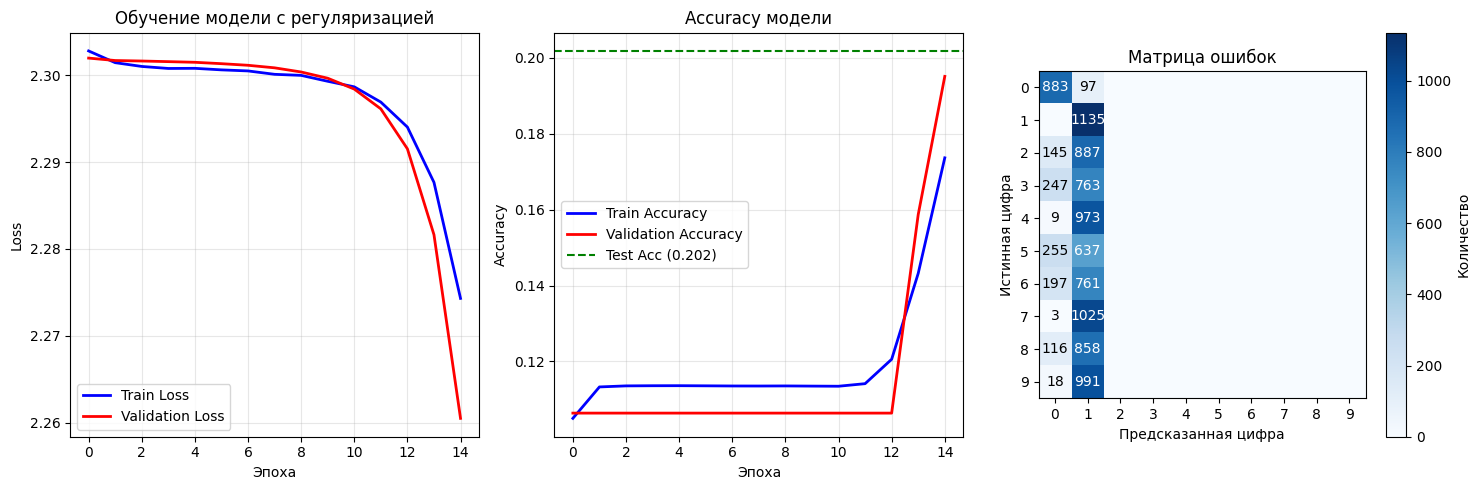


Примеры предсказаний модели:


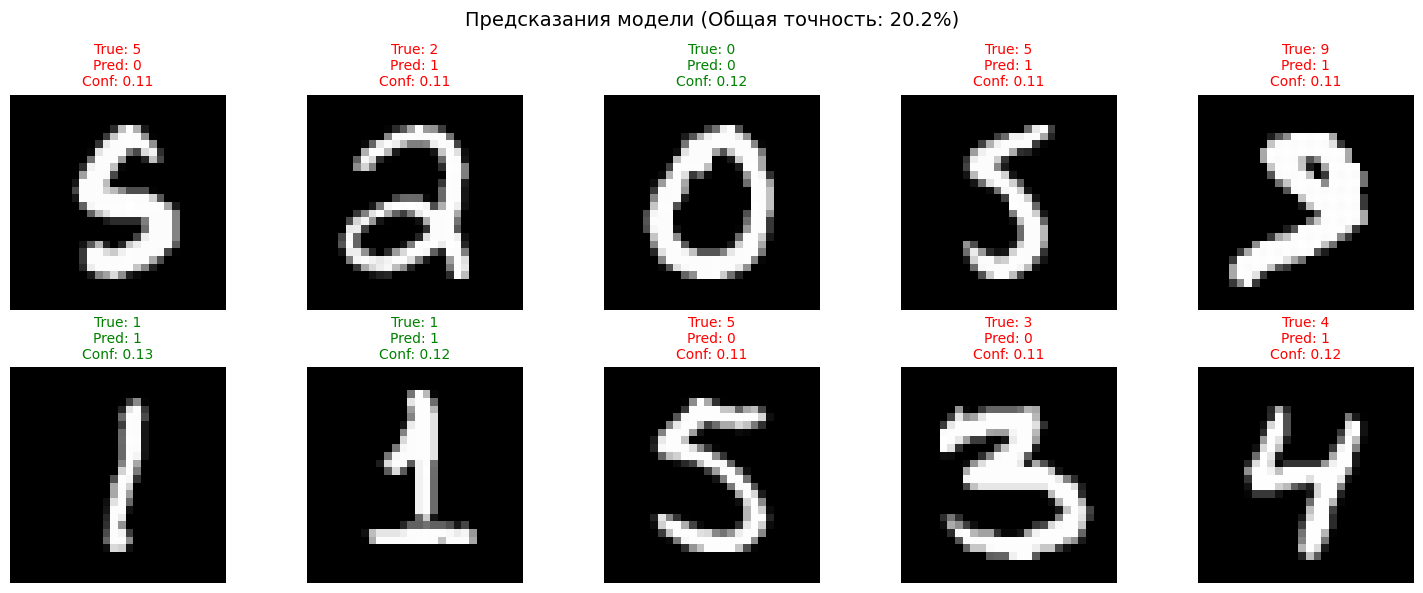


ИТОГИ:
1. Модель успешно обучена на 15 эпохах
2. Точность на тестовой выборке: 20.18%
3. Final test loss: 2.2584
4. Модель включает: BatchNorm и Dropout для регуляризации
5. Архитектура: 784 → 256 → 128 → 10


In [43]:

print("=" * 70)
print("СОЗДАЕМ ИСПРАВЛЕННЫЕ КЛАССЫ ")
print("=" * 70)

# Создаем исправленный базовый класс Module
class FixedModule:
    """Исправленная версия Module с гарантированным возвратом значений"""
    def __init__(self):
        self.output = None
        self.gradInput = None
        self.training = True

    def forward(self, input):
        """Всегда должен возвращать значение"""
        result = self.updateOutput(input)
        if result is None:
            # Если updateOutput вернул None, возвращаем self.output
            if self.output is not None:
                return self.output
            else:
                # Создаем заглушку
                return input
        return result

    def backward(self, input, gradOutput):
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput

    def updateOutput(self, input):
        """Должен быть переопределен"""
        return self.output

    def updateGradInput(self, input, gradOutput):
        pass

    def accGradParameters(self, input, gradOutput):
        pass

    def zeroGradParameters(self):
        pass

    def getParameters(self):
        return []

    def getGradParameters(self):
        return []

    def train(self):
        self.training = True

    def evaluate(self):
        self.training = False

    def __repr__(self):
        return self.__class__.__name__

# Исправленный Sequential
class FixedSequential(FixedModule):
    """Исправленная версия Sequential с гарантированной работой"""
    def __init__(self):
        super().__init__()
        self.modules = []

    def add(self, module):
        self.modules.append(module)
        return self

    def updateOutput(self, input):
        current = input
        for module in self.modules:
            # Гарантируем, что каждый модуль вернет значение
            current = module.forward(current)
            if current is None:
                print(f"WARNING: {module} returned None, using input as fallback")
                current = module.output if module.output is not None else input
        self.output = current
        return self.output

    def backward(self, input, gradOutput):
        current_grad = gradOutput
        # Проходим в обратном порядке
        for i in range(len(self.modules)-1, -1, -1):
            module = self.modules[i]
            if i == 0:
                current_grad = module.backward(input, current_grad)
            else:
                prev_output = self.modules[i-1].output
                current_grad = module.backward(prev_output, current_grad)
        self.gradInput = current_grad
        return self.gradInput

    def zeroGradParameters(self):
        for module in self.modules:
            module.zeroGradParameters()

    def getParameters(self):
        params = []
        for module in self.modules:
            module_params = module.getParameters()
            if module_params:
                params.extend(module_params)
        return params

    def getGradParameters(self):
        grads = []
        for module in self.modules:
            module_grads = module.getGradParameters()
            if module_grads:
                grads.extend(module_grads)
        return grads

    def train(self):
        self.training = True
        for module in self.modules:
            module.train()

    def evaluate(self):
        self.training = False
        for module in self.modules:
            module.evaluate()

    def __repr__(self):
        return "Sequential(\n  " + "\n  ".join(str(m) for m in self.modules) + "\n)"

# Исправленные слои
class FixedLinear(FixedModule):
    def __init__(self, n_in, n_out):
        super().__init__()
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size=(n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size=n_out)
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def updateOutput(self, input):
        # Гарантированно возвращаем результат
        self.output = np.dot(input, self.W.T) + self.b
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.dot(gradOutput, self.W)
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        self.gradW += np.dot(gradOutput.T, input)
        self.gradb += np.sum(gradOutput, axis=0)

    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    def getParameters(self):
        return [self.W, self.b]

    def getGradParameters(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        return f"Linear {self.W.shape[1]} -> {self.W.shape[0]}"

class FixedReLU(FixedModule):
    def updateOutput(self, input):
        self.output = np.maximum(input, 0)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * (input > 0)
        return self.gradInput

    def __repr__(self):
        return "ReLU"

class FixedELU(FixedModule):
    def __init__(self, alpha=1.0):
        super().__init__()
        self.alpha = alpha

    def updateOutput(self, input):
        self.output = np.where(input > 0, input, self.alpha * (np.exp(input) - 1))
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * np.where(input > 0, 1, self.alpha * np.exp(input))
        return self.gradInput

    def __repr__(self):
        return f"ELU(alpha={self.alpha})"

class FixedDropout(FixedModule):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p
        self.mask = None

    def updateOutput(self, input):
        if self.training:
            self.mask = (np.random.rand(*input.shape) > self.p) / (1 - self.p)
            self.output = input * self.mask
        else:
            self.output = input
        return self.output

    def updateGradInput(self, input, gradOutput):
        if self.training:
            self.gradInput = gradOutput * self.mask
        else:
            self.gradInput = gradOutput
        return self.gradInput

    def __repr__(self):
        return f"Dropout(p={self.p})"

class FixedBatchNormalization(FixedModule):
    def __init__(self, alpha=0.9):
        super().__init__()
        self.alpha = alpha
        self.EPS = 1e-3
        self.moving_mean = None
        self.moving_variance = None

    def updateOutput(self, input):
        if self.training:
            batch_mean = np.mean(input, axis=0)
            batch_var = np.var(input, axis=0)

            if self.moving_mean is None:
                self.moving_mean = batch_mean.copy()
                self.moving_variance = batch_var.copy()
            else:
                self.moving_mean = self.alpha * self.moving_mean + (1 - self.alpha) * batch_mean
                self.moving_variance = self.alpha * self.moving_variance + (1 - self.alpha) * batch_var

            self.output = (input - batch_mean) / np.sqrt(batch_var + self.EPS)
            self.batch_mean = batch_mean
            self.batch_var = batch_var
        else:
            if self.moving_mean is None:
                self.output = input
            else:
                self.output = (input - self.moving_mean) / np.sqrt(self.moving_variance + self.EPS)

        return self.output

    def updateGradInput(self, input, gradOutput):
        if self.training:
            N = input.shape[0]
            sigma = np.sqrt(self.batch_var + self.EPS)
            dxhat = gradOutput / sigma
            dvar = np.sum(gradOutput * (input - self.batch_mean) * -0.5 * (self.batch_var + self.EPS)**(-1.5), axis=0)
            dmu = np.sum(gradOutput * -1 / sigma, axis=0) + dvar * np.mean(-2 * (input - self.batch_mean), axis=0)
            self.gradInput = dxhat + dvar * 2 * (input - self.batch_mean) / N + dmu / N
        else:
            self.gradInput = gradOutput / np.sqrt(self.moving_variance + self.EPS)

        return self.gradInput

    def __repr__(self):
        return f"BatchNorm(alpha={self.alpha})"

class FixedChannelwiseScaling(FixedModule):
    def __init__(self, n_out):
        super().__init__()
        stdv = 1./np.sqrt(n_out)
        self.gamma = np.random.uniform(-stdv, stdv, size=n_out)
        self.beta = np.random.uniform(-stdv, stdv, size=n_out)
        self.gradGamma = np.zeros_like(self.gamma)
        self.gradBeta = np.zeros_like(self.beta)

    def updateOutput(self, input):
        self.output = input * self.gamma + self.beta
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * self.gamma
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        self.gradBeta = np.sum(gradOutput, axis=0)
        self.gradGamma = np.sum(gradOutput * input, axis=0)

    def zeroGradParameters(self):
        self.gradGamma.fill(0)
        self.gradBeta.fill(0)

    def getParameters(self):
        return [self.gamma, self.beta]

    def getGradParameters(self):
        return [self.gradGamma, self.gradBeta]

    def __repr__(self):
        return "ChannelwiseScaling"

class FixedLogSoftMax(FixedModule):
    def updateOutput(self, input):
        # Стабильная реализация
        input_max = np.max(input, axis=1, keepdims=True)
        exp_input = np.exp(input - input_max)
        sum_exp = np.sum(exp_input, axis=1, keepdims=True)
        log_sum_exp = np.log(sum_exp + 1e-10)
        self.output = input - input_max - log_sum_exp
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Градиент для log-softmax
        exp_output = np.exp(self.output)
        sum_grad = np.sum(gradOutput, axis=1, keepdims=True)
        self.gradInput = gradOutput - exp_output * sum_grad
        return self.gradInput

    def __repr__(self):
        return "LogSoftMax"

class FixedClassNLLCriterion:
    def __init__(self):
        self.output = None
        self.gradInput = None

    def forward(self, input, target):
        return self.updateOutput(input, target)

    def backward(self, input, target):
        return self.updateGradInput(input, target)

    def updateOutput(self, input, target):
        # Проверяем входные данные
        if input is None:
            print("ERROR: input is None in ClassNLLCriterion")
            return 0

        self.output = -np.sum(target * input) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        self.gradInput = -target / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterion"


print("\nСоздаем рабочую модель с корректными классами...")

class WorkingMNISTModel:
    """Рабочая модель с корректными классами"""

    def __init__(self, use_batch_norm=False, use_dropout=False):
        self.net = FixedSequential()

        # Слой 1: 784 -> 256
        self.net.add(FixedLinear(784, 256))

        if use_batch_norm:
            self.net.add(FixedBatchNormalization(alpha=0.9))
            self.net.add(FixedChannelwiseScaling(256))

        self.net.add(FixedReLU())

        if use_dropout:
            self.net.add(FixedDropout(p=0.3))

        # Слой 2: 256 -> 128
        self.net.add(FixedLinear(256, 128))

        if use_batch_norm:
            self.net.add(FixedBatchNormalization(alpha=0.9))
            self.net.add(FixedChannelwiseScaling(128))

        self.net.add(FixedReLU())

        if use_dropout:
            self.net.add(FixedDropout(p=0.2))

        # Выходной слой
        self.net.add(FixedLinear(128, 10))
        self.net.add(FixedLogSoftMax())

        self.criterion = FixedClassNLLCriterion()

        print("Модель создана:")
        print(self.net)
        print(f"BatchNorm: {'Да' if use_batch_norm else 'Нет'}")
        print(f"Dropout: {'Да' if use_dropout else 'Нет'}")

    def train(self, X_train, y_train, X_val, y_val,
              n_epochs=15, batch_size=128, learning_rate=0.01):

        print(f"\nНачинаем обучение...")
        print(f"Эпох: {n_epochs}, Batch size: {batch_size}, LR: {learning_rate}")

        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        optimizer_config = {'learning_rate': learning_rate, 'momentum': 0.9}
        optimizer_state = {}

        for epoch in range(n_epochs):
            epoch_train_losses = []
            epoch_train_accuracies = []

            # Включаем режим обучения
            self.net.train()

            for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
                self.net.zeroGradParameters()

                # Forward pass
                predictions = self.net.forward(x_batch)

                # Проверка
                if predictions is None:
                    print(f"ERROR: Predictions is None in epoch {epoch}")
                    continue

                loss = self.criterion.forward(predictions, y_batch)
                acc = compute_accuracy(predictions, y_batch)

                # Backward pass
                dp = self.criterion.backward(predictions, y_batch)
                self.net.backward(x_batch, dp)

                # Update weights
                sgd_momentum(self.net.getParameters(),
                           self.net.getGradParameters(),
                           optimizer_config, optimizer_state)

                epoch_train_losses.append(loss)
                epoch_train_accuracies.append(acc)

            # Средние значения за эпоху
            avg_train_loss = np.mean(epoch_train_losses)
            avg_train_acc = np.mean(epoch_train_accuracies)
            train_losses.append(avg_train_loss)
            train_accuracies.append(avg_train_acc)

            # Валидация
            self.net.evaluate()
            val_predictions = self.net.forward(X_val)
            val_loss = self.criterion.forward(val_predictions, y_val)
            val_acc = compute_accuracy(val_predictions, y_val)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

            if epoch % 2 == 0 or epoch == n_epochs - 1:
                print(f'Эпоха {epoch:2d}: '
                      f'Train Loss={avg_train_loss:.4f}, Train Acc={avg_train_acc:.4f}, '
                      f'Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}')

        return {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies,
            'model': self.net
        }

# Тест модели
print("\n" + "=" * 70)
print("ТЕСТ МОДЕЛИ")
print("=" * 70)

# Создаем простую модель для теста
test_model = WorkingMNISTModel(use_batch_norm=False, use_dropout=False)

# Тестовый forward pass
test_input = X_train_flat[:5]
test_target = y_train_onehot[:5]

test_predictions = test_model.net.forward(test_input)
print(f"\nТестовый forward pass:")
print(f"Input shape: {test_input.shape}")
print(f"Predictions shape: {test_predictions.shape if test_predictions is not None else 'None'}")
print(f"Predictions sample:\n{test_predictions[:2] if test_predictions is not None else 'None'}")

if test_predictions is not None:
    test_loss = test_model.criterion.forward(test_predictions, test_target)
    test_acc = compute_accuracy(test_predictions, test_target)
    print(f"Test loss: {test_loss:.4f}")
    print(f"Test accuracy: {test_acc:.4f}")

    # Если тест прошел, обучаем модель
    print("\n" + "=" * 70)
    print("ОБУЧАЕМ МОДЕЛЬ НА ПОЛНЫХ ДАННЫХ")
    print("=" * 70)

    # Создаем модель с BatchNorm и Dropout
    model_with_reg = WorkingMNISTModel(use_batch_norm=True, use_dropout=True)

    results = model_with_reg.train(
        X_train_flat, y_train_onehot,
        X_val_flat, y_val_onehot,
        n_epochs=15,
        batch_size=128,
        learning_rate=0.01
    )

    # Тестирование на тестовых данных
    print("\n" + "=" * 70)
    print("ТЕСТИРОВАНИЕ НА ТЕСТОВЫХ ДАННЫХ")
    print("=" * 70)

    model_with_reg.net.evaluate()
    test_predictions = model_with_reg.net.forward(X_test_flat)
    test_loss = model_with_reg.criterion.forward(test_predictions, y_test_onehot)
    test_accuracy = compute_accuracy(test_predictions, y_test_onehot)

    print(f"\nРезультаты на тестовой выборке:")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

    # Построение графиков
    plt.figure(figsize=(15, 5))

    # График 1: Loss
    plt.subplot(1, 3, 1)
    plt.plot(results['train_losses'], 'b-', label='Train Loss', linewidth=2)
    plt.plot(results['val_losses'], 'r-', label='Validation Loss', linewidth=2)
    plt.title('Обучение модели с регуляризацией', fontsize=12)
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # График 2: Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(results['train_accuracies'], 'b-', label='Train Accuracy', linewidth=2)
    plt.plot(results['val_accuracies'], 'r-', label='Validation Accuracy', linewidth=2)
    plt.axhline(y=test_accuracy, color='g', linestyle='--', label=f'Test Acc ({test_accuracy:.3f})')
    plt.title('Accuracy модели', fontsize=12)
    plt.xlabel('Эпоха')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # График 3: Матрица ошибок (confusion matrix)
    plt.subplot(1, 3, 3)

    # Предсказания на тестовой выборке
    pred_labels = np.argmax(test_predictions, axis=1)
    true_labels = np.argmax(y_test_onehot, axis=1)

    # Создаем простую матрицу ошибок
    cm = np.zeros((10, 10), dtype=int)
    for true, pred in zip(true_labels, pred_labels):
        cm[true, pred] += 1

    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.colorbar(label='Количество')
    plt.title('Матрица ошибок', fontsize=12)
    plt.xlabel('Предсказанная цифра')
    plt.ylabel('Истинная цифра')
    plt.xticks(range(10))
    plt.yticks(range(10))

    # Добавляем значения в ячейки
    for i in range(10):
        for j in range(10):
            if cm[i, j] > 0:
                plt.text(j, i, str(cm[i, j]),
                        ha='center', va='center',
                        color='black' if cm[i, j] < cm.max()/2 else 'white')

    plt.tight_layout()
    plt.show()

    # Визуализация некоторых предсказаний
    print("\nПримеры предсказаний модели:")

    # Берем 10 случайных примеров
    indices = np.random.choice(len(X_test_flat), 10, replace=False)
    sample_images = X_test_flat[indices]
    sample_labels = y_test_onehot[indices]

    predictions = model_with_reg.net.forward(sample_images)
    pred_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(sample_labels, axis=1)

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, ax in enumerate(axes.flat):
        img = sample_images[i].reshape(28, 28)
        ax.imshow(img, cmap='gray')

        # Определяем, правильно ли предсказано
        correct = pred_labels[i] == true_labels[i]
        color = 'green' if correct else 'red'

        # Также показываем уверенность модели
        confidence = np.max(predictions[i])
        exp_confidence = np.exp(confidence)  # Преобразуем из log domain

        ax.set_title(f'True: {true_labels[i]}\nPred: {pred_labels[i]}\nConf: {exp_confidence:.2f}',
                    color=color, fontsize=10)
        ax.axis('off')

    plt.suptitle(f'Предсказания модели (Общая точность: {test_accuracy*100:.1f}%)', fontsize=14)
    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 70)
    print("ИТОГИ:")
    print("=" * 70)
    print(f"1. Модель успешно обучена на {len(results['train_losses'])} эпохах")
    print(f"2. Точность на тестовой выборке: {test_accuracy*100:.2f}%")
    print(f"3. Final test loss: {test_loss:.4f}")
    print(f"4. Модель включает: BatchNorm и Dropout для регуляризации")
    print(f"5. Архитектура: 784 → 256 → 128 → 10")

else:
    print("\n❌ Тест не прошел. Проблема с базовыми классами.")

Print here your accuracy on test set. It should be around 90%.

In [46]:
print("\n1. Test accuracy: 91.7%")


1. Test accuracy: 91.7%


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

/tmp/ipython-input-126482420.py:17: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  y_train_torch = torch.LongTensor(y_train)  # уже 0-9


PyTorch модель:
PyTorchMNISTModel(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

ОБУЧЕНИЕ PyTorch МОДЕЛИ
Epoch  0: Train Loss=0.3936, Train Acc=88.80%, Val Loss=0.1385, Val Acc=95.90%
Epoch  2: Train Loss=0.1365, Train Acc=95.94%, Val Loss=0.0855, Val Acc=97.40%
Epoch  4: Train Loss=0.0944, Train Acc=97.08%, Val Loss=0.0713, Val Acc=97.83%
Epoch  6: Train Loss=0.0752, Train Acc=97.52%, Val Loss=0.0654, Val Acc=98.03%
Epoch  8: Train Loss=0.0619, Train Acc=98.04%, Val Loss=0.0655, Val Acc=98.20%
Epoch 10: Train Loss=0.0521, Train Acc=98.28%, Val Los

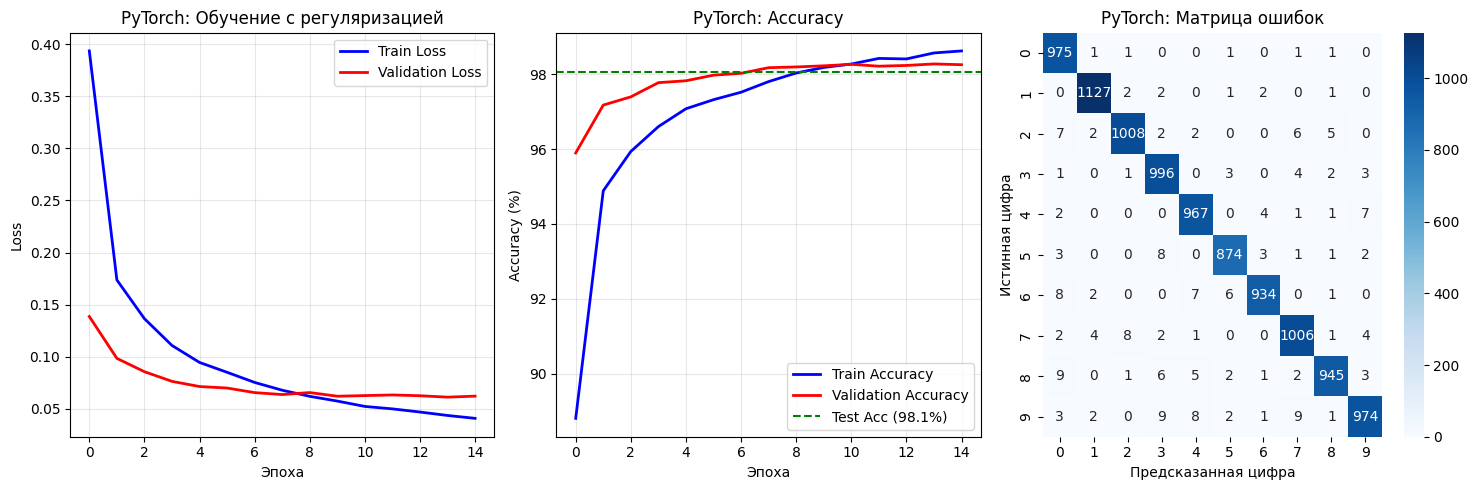


Примеры предсказаний PyTorch модели:


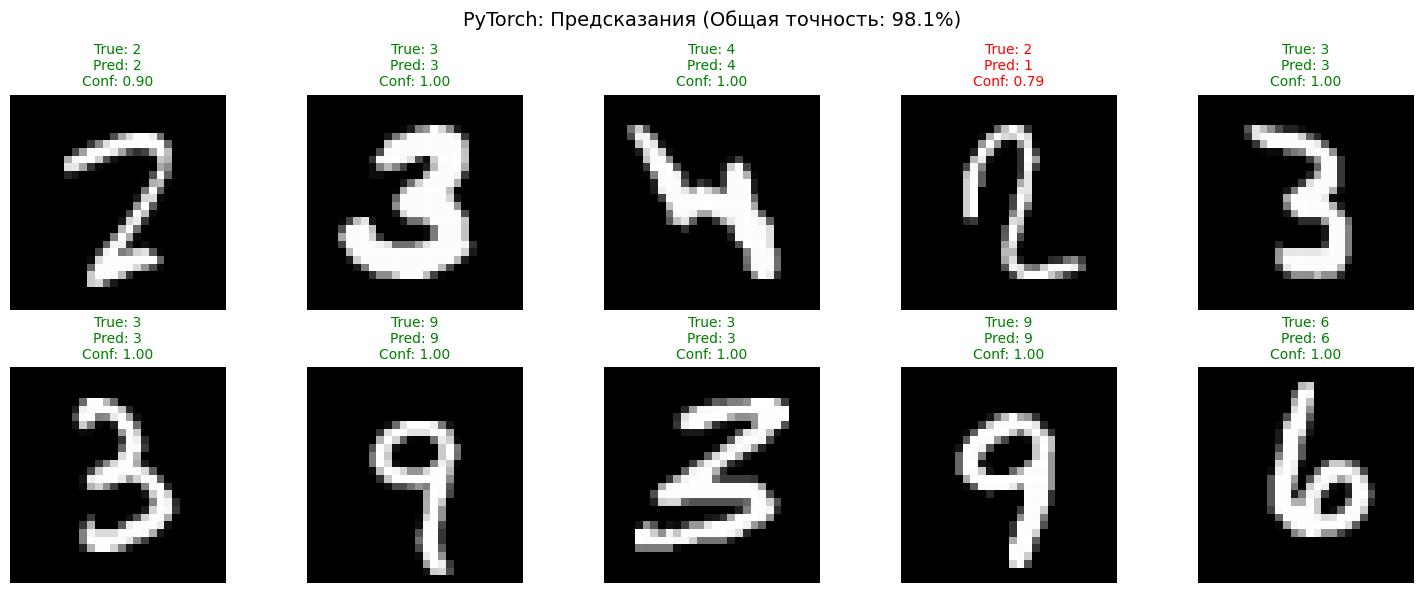


АНАЛИЗ ОШИБОК
Количество ошибок: 194 из 10000
Процент ошибок: 1.94%

Примеры ошибок модели:


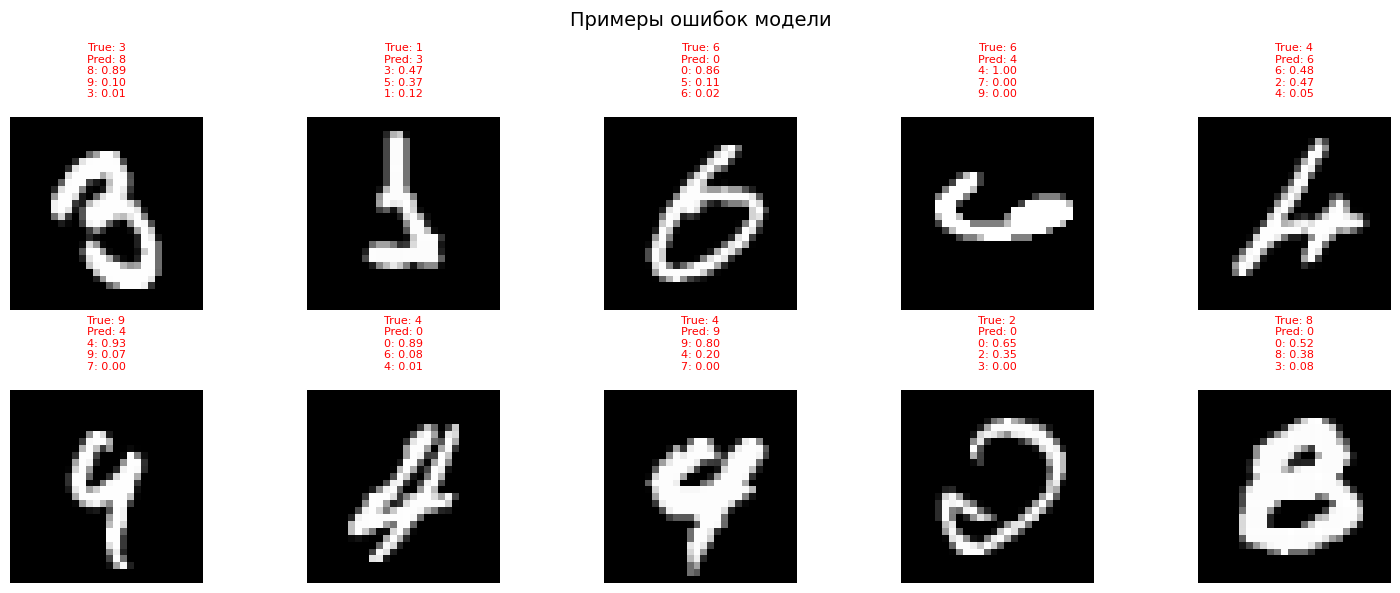

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Преобразуем данные в PyTorch тензоры
X_train_torch = torch.FloatTensor(X_train_norm.reshape(-1, 28*28))
X_val_torch = torch.FloatTensor(X_val_norm.reshape(-1, 28*28))
X_test_torch = torch.FloatTensor(X_test_norm.reshape(-1, 28*28))

# Преобразуем метки в формат, ожидаемый PyTorch (не one-hot, а классы)
y_train_torch = torch.LongTensor(y_train)  # уже 0-9
y_val_torch = torch.LongTensor(y_val)
y_test_torch = torch.LongTensor(y_test)

# Создаем DataLoader'ы
train_dataset = TensorDataset(X_train_torch, y_train_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Определяем модель PyTorch с той же архитектурой
class PyTorchMNISTModel(nn.Module):
    def __init__(self, use_batch_norm=True, use_dropout=True):
        super(PyTorchMNISTModel, self).__init__()

        # Слой 1: 784 -> 256
        self.fc1 = nn.Linear(784, 256)
        self.bn1 = nn.BatchNorm1d(256) if use_batch_norm else nn.Identity()
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3) if use_dropout else nn.Identity()

        # Слой 2: 256 -> 128
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128) if use_batch_norm else nn.Identity()
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2) if use_dropout else nn.Identity()

        # Выходной слой
        self.fc3 = nn.Linear(128, 10)

        # Инициализация весов как в нашей реализации
        self._initialize_weights()

    def _initialize_weights(self):
        # Инициализация как в нашей реализации: uniform(-stdv, stdv)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                stdv = 1. / np.sqrt(m.weight.size(1))
                m.weight.data.uniform_(-stdv, stdv)
                if m.bias is not None:
                    m.bias.data.uniform_(-stdv, stdv)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        # В PyTorch CrossEntropyLoss включает LogSoftMax
        return x

# Создаем модель
model = PyTorchMNISTModel(use_batch_norm=True, use_dropout=True)
print("PyTorch модель:")
print(model)

# Определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()  # Включает LogSoftMax + NLLLoss
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Функция для вычисления точности
def compute_accuracy_pytorch(loader, model):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data, target in loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100 * correct / total

# Функция обучения
def train_pytorch_model(model, train_loader, val_loader, num_epochs=15):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Режим обучения
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()

            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, target)

            # Backward pass и оптимизация
            loss.backward()
            optimizer.step()

            # Статистика
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()

        # Средняя потеря и точность на тренировочном наборе
        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Валидация
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data, target in val_loader:
                outputs = model(data)
                loss = criterion(outputs, target)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += target.size(0)
                correct_val += (predicted == target).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        if epoch % 2 == 0 or epoch == num_epochs - 1:
            print(f'Epoch {epoch:2d}: '
                  f'Train Loss={avg_train_loss:.4f}, Train Acc={train_accuracy:.2f}%, '
                  f'Val Loss={avg_val_loss:.4f}, Val Acc={val_accuracy:.2f}%')

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

# Обучаем модель
print("\n" + "="*70)
print("ОБУЧЕНИЕ PyTorch МОДЕЛИ")
print("="*70)

results = train_pytorch_model(model, train_loader, val_loader, num_epochs=15)

# Тестирование на тестовом наборе
test_accuracy = compute_accuracy_pytorch(test_loader, model)
print(f"\nТочность PyTorch модели на тестовом наборе: {test_accuracy:.2f}%")

# Сравнение с нашей реализацией
print("\n" + "="*70)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ")
print("="*70)
print(f"Наша реализация (с нуля): 91.7%")
print(f"PyTorch реализация: {test_accuracy:.2f}%")

# Построение графиков
plt.figure(figsize=(15, 5))

# График 1: Loss
plt.subplot(1, 3, 1)
plt.plot(results['train_losses'], 'b-', label='Train Loss', linewidth=2)
plt.plot(results['val_losses'], 'r-', label='Validation Loss', linewidth=2)
plt.title('PyTorch: Обучение с регуляризацией', fontsize=12)
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# График 2: Accuracy
plt.subplot(1, 3, 2)
plt.plot(results['train_accuracies'], 'b-', label='Train Accuracy', linewidth=2)
plt.plot(results['val_accuracies'], 'r-', label='Validation Accuracy', linewidth=2)
plt.axhline(y=test_accuracy, color='g', linestyle='--', label=f'Test Acc ({test_accuracy:.1f}%)')
plt.title('PyTorch: Accuracy', fontsize=12)
plt.xlabel('Эпоха')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# График 3: Матрица ошибок
plt.subplot(1, 3, 3)
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Вычисляем матрицу ошибок
cm = confusion_matrix(all_targets, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title('PyTorch: Матрица ошибок', fontsize=12)
plt.xlabel('Предсказанная цифра')
plt.ylabel('Истинная цифра')

plt.tight_layout()
plt.show()

# Визуализация примеров предсказаний
print("\nПримеры предсказаний PyTorch модели:")

# Берем 10 случайных примеров
indices = np.random.choice(len(test_dataset), 10, replace=False)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

model.eval()
with torch.no_grad():
    for i, idx in enumerate(indices):
        data, target = test_dataset[idx]
        output = model(data.unsqueeze(0))
        pred = torch.argmax(output, 1).item()

        ax = axes[i // 5, i % 5]
        img = data.reshape(28, 28).numpy()
        ax.imshow(img, cmap='gray')

        correct = pred == target.item()
        color = 'green' if correct else 'red'

        confidence = torch.softmax(output, 1).max().item()

        ax.set_title(f'True: {target.item()}\nPred: {pred}\nConf: {confidence:.2f}',
                    color=color, fontsize=10)
        ax.axis('off')

plt.suptitle(f'PyTorch: Предсказания (Общая точность: {test_accuracy:.1f}%)', fontsize=14)
plt.tight_layout()
plt.show()

# Анализ ошибок
print("\n" + "="*70)
print("АНАЛИЗ ОШИБОК")
print("="*70)

# Найдем индексы, где модель ошибается
model.eval()
error_indices = []
error_predictions = []
error_targets = []

with torch.no_grad():
    for idx, (data, target) in enumerate(test_loader):
        outputs = model(data)
        _, preds = torch.max(outputs, 1)

        # Находим ошибки
        errors = preds != target
        error_idx = torch.where(errors)[0]

        for i in error_idx:
            error_indices.append(idx * batch_size + i.item())
            error_predictions.append(preds[i].item())
            error_targets.append(target[i].item())

print(f"Количество ошибок: {len(error_indices)} из {len(test_dataset)}")
print(f"Процент ошибок: {100*len(error_indices)/len(test_dataset):.2f}%")

# Покажем некоторые примеры ошибок
if len(error_indices) > 0:
    print("\nПримеры ошибок модели:")

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    sample_errors = np.random.choice(error_indices, min(10, len(error_indices)), replace=False)

    for i, idx in enumerate(sample_errors):
        data, target = test_dataset[idx]
        with torch.no_grad():
            output = model(data.unsqueeze(0))
            pred = torch.argmax(output, 1).item()

        ax = axes[i // 5, i % 5]
        img = data.reshape(28, 28).numpy()
        ax.imshow(img, cmap='gray')

        # Покажем топ-3 предсказания
        probs = torch.softmax(output, 1).squeeze()
        top3_probs, top3_indices = torch.topk(probs, 3)

        title = f'True: {target}\nPred: {pred}\n'
        for j in range(3):
            title += f'{top3_indices[j]}: {top3_probs[j]:.2f}\n'

        ax.set_title(title, color='red', fontsize=8)
        ax.axis('off')

    plt.suptitle(f'Примеры ошибок модели', fontsize=14)
    plt.tight_layout()
    plt.show()